# HW2 for CS 135 in Spring 2024

This notebook is specifically for the report related to Problem 1

# Problem 1: Binary Classifier for Cancer-Risk Screening 

### Note: 
* You will need to finish **Code Task** for **Problem 1** before working on this notebook. 
* Your outputs, including tables and figures, don't need to be exactly the same as our sample outputs, but we do expect something as clear.

In [2]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics

In [3]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

# autoload changes in other files, so you don't have to restart the Jupyter kernel each time you make a change to the imported code.
%load_ext autoreload
%autoreload 2

# Import student-edited code 

Remember, you should have *completed* the Code Tasks for Problem 1 first.

In [4]:
if not os.path.exists('binary_metrics.py'):
    raise ImportError("CANNOT FIND binary_metrics.py. Make sure you run this notebook in same directory as your .py files.")

In [5]:
from binary_metrics import (
    calc_ACC, calc_TPR, calc_PPV)

# Import helper code (will work as provided, no edits needed)

In [6]:
import threshold_selection

In [7]:
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

# Provided function for computing mean binary cross entropy

Here, we provide a *completed* function you can use as is for Problem 1 report.

Later in Problem 2, you'll write your own version of this function without using sklearn.

Remember, we want the *base-2* cross entropy:

$$
BCE(y, p) = - y \log_2 p - (1-y) \log_2(1-p)
$$

In [8]:
def calc_mean_binary_cross_entropy_from_probas(ytrue_N, yproba1_N):
    ''' Compute mean binary cross entropy
    
    Args
    ----
    ytrue_N : 1D array, size (n_examples,) = (N,)
    yproba1_N : 1D array, size (n_examples,) = (N,)
    
    Returns
    -------
    mean_bce : float
        mean binary cross entropy across all N examples
    '''
    return sklearn.metrics.log_loss(ytrue_N, yproba1_N, labels=[0,1]) / np.log(2.0)

In [9]:
# Check that BCE loss is high if true class is 1 but probability is low
calc_mean_binary_cross_entropy_from_probas([1.], [0.01])

6.643856189774724

In [10]:
# Check that BCE loss is exactly 1 if true class is 1 but probability is 0.5
calc_mean_binary_cross_entropy_from_probas([1.], [0.5])

1.0

In [11]:
# Check that BCE loss is close to zero if true class is 1 but probability is 0.99
calc_mean_binary_cross_entropy_from_probas([1.], [0.99])

0.01449956969511509

# Load the dataset for problem 1

In [12]:
# Make sure you have downloaded data and your directory is correct
DATA_DIR = os.path.join('data_cancer') 

In [13]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt(os.path.join(DATA_DIR, 'x_valid.csv'), delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

for label, x in [('train', x_tr_M3), ('valid', x_va_N3), ('test', x_te_N3)]:
    print("Loaded %6s : shape %s" % (label, x.shape))

Loaded  train : shape (390, 3)
Loaded  valid : shape (180, 3)
Loaded   test : shape (180, 3)


In [14]:
N_shape = x_va_N3.shape
M_shape = x_tr_M3.shape

N = N_shape[0]
M = M_shape[0]

**TODO** : Load outcomes **y** arrays

In [15]:
# Load outcomes y arrays
# Hint: Follow the way we import x arrays.
y_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)
y_va_N = np.loadtxt(os.path.join(DATA_DIR, 'y_valid.csv'), delimiter=',', skiprows=1)
y_te_N = np.loadtxt(os.path.join(DATA_DIR, 'y_test.csv'), delimiter=',', skiprows=1)

In [16]:
# Load 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

# Problem 1:
## Implementation Step 1A: Data Exploration

### Table 1 

Provide a table summarizing some basic properties of the provided training set, validation set, and test set:

* Row 1 'total count': how many total examples are in each set?
* Row 2 'positive label count': how many examples have a positive label (means cancer)?
* Row 3 'fraction positive' : what fraction (between 0 and 1) of the examples have cancer?

Your result should be 3 by 3 containing 'total count', 'positive label count' and 'fraction positive' of training, valid and test sets. An example of the output looks like this:

|                               | train  |valid    |test|
|:-|-:|-:|-:|
|num. total examples            |567.000  |123.000  |123.000
|num. positive examples         |56.000   |23.000   |23.000
|fraction of positive examples  |0.123    |0.123    |0.123

All results should **keep 3 digits**. We set a pandas display option to ensure that below.

**TODO**: make a pandas dataframe with the correct data properties

In [17]:
total_train = len(x_tr_M3)
positive_train = np.count_nonzero(y_tr_M == 1)
ratio_train = positive_train / total_train

total_valid = len(x_va_N3)
positive_valid = np.count_nonzero(y_va_N == 1)
ratio_valid = positive_valid / total_valid

total_test = len(x_te_N3)
positive_test = np.count_nonzero(y_te_N == 1)
ratio_test = positive_test / total_test

table1_df = pd.DataFrame({
        'train':[total_train, positive_train, ratio_train],
        'valid':[total_valid, positive_valid, ratio_valid],
        'test':[total_test, positive_test, ratio_test]
})
table1_df.index = ['num. total examples', 'num. positive examples', 'fraction of positive examples']

In [18]:
pd.set_option('display.precision', 3)
print(table1_df)

                                 train    valid     test
num. total examples            390.000  180.000  180.000
num. positive examples          55.000   25.000   25.000
fraction of positive examples    0.141    0.139    0.139


##  Implementation Step 1B: The predict-0-always baseline

**TODO**: predict zero for all test data points

In [19]:
# baseline_yhat_te_N = np.random.RandomState(0).randint(low=0, high=2, size=N) # TODO fixme
baseline_yhat_te_N = np.zeros(N)
print(baseline_yhat_te_N)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [20]:
print(y_te_N)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [21]:
print(calc_confusion_matrix_for_probas_and_threshold(y_te_N, baseline_yhat_te_N, 0.5))

Predicted    0  1
True             
0          155  0
1           25  0


**TODO** Use the printed information from the previous code cell to calculate the accuracy of baseline. 

Keep 3 digits in your PDF report for short Answer 1a.

In [22]:
baseline_acc = calc_ACC(y_te_N, baseline_yhat_te_N)
print("Baseline has accuracy: ", baseline_acc)

Baseline has accuracy:  0.8611111111106328


#### Short Answer 1a in Report

*See instructions in the Piazza post for HW2*

## Implementation Step 1C : Logistic Regression with F=2 dataset

**TODO**: Complete each line marked TODO fixme in the codeblock below

In [23]:
C_grid = np.logspace(-9, 6, 31)

# We will fit a separate logistic regression for each C value in the C_grid
# And store that classifier's performance metrics (lower is better)
# So we can compare and select the best C in the future steps.

model_F2_list = list()

# Allocate lists for storing BCE metrics
tr_bce_list = list()
va_bce_list = list()
te_bce_list = list()

# Allocate lists for storing ERROR RATE metrics
tr_err_list = list()
va_err_list = list()
te_err_list = list()

# Remember, we justified BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.

# Loop over C values, fit models, record metrics
for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize a LogisticRegression classifier with desired C value
    # Part b: train the model with the 2-feature dataset
    lr_F2 = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=C) # TODO fixme
    lr_F2.fit(x_tr_M2[:], y_tr_M[:]) # TODO fixme
    
    model_F2_list.append(lr_F2)
    
    yproba1_tr_M = lr_F2.predict_proba(x_tr_M2)[:,1] # The probability of predicting class 1 on the training set
    yproba1_va_N = lr_F2.predict_proba(x_va_N2)[:,1] # The probability of predicting class 1 on the validation set
    
    # Compute error rate aka zero-one loss
    my_tr_err = sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)
    my_va_err = sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)
    tr_err_list.append(my_tr_err)
    va_err_list.append(my_va_err)
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my_tr_bce = calc_mean_binary_cross_entropy_from_probas(y_tr_M, yproba1_tr_M) # TODO fixme
    my_va_bce = calc_mean_binary_cross_entropy_from_probas(y_va_N, yproba1_va_N) # TODO fixme
    # Save bce for future selection on Models.
    tr_bce_list.append(my_tr_bce) 
    va_bce_list.append(my_va_bce) 

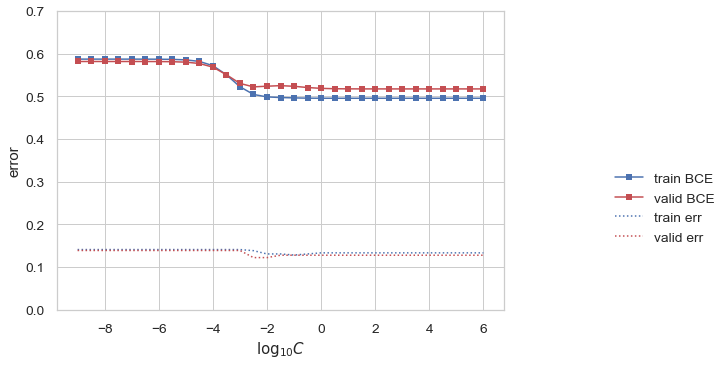

In [24]:
plt.plot(np.log10(C_grid), tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), va_bce_list, 'rs-', label='valid BCE')

plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 0.7]);

### Check Point:

If your code is correct, you should produce exactly the same figure when you run the cell above as:

**"Checkpoint1C.jpg"** in the same folder as your starter code.
![image.png](Checkpoint1C.JPG)

In [25]:
print("Searched over these C values:")
print(C_grid)

print("Recorded these BCE loss values on val set")
print(va_bce_list)

Searched over these C values:
[1.00000000e-09 3.16227766e-09 1.00000000e-08 3.16227766e-08
 1.00000000e-07 3.16227766e-07 1.00000000e-06 3.16227766e-06
 1.00000000e-05 3.16227766e-05 1.00000000e-04 3.16227766e-04
 1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03 3.16227766e+03 1.00000000e+04 3.16227766e+04
 1.00000000e+05 3.16227766e+05 1.00000000e+06]
Recorded these BCE loss values on val set
[0.5813486462944975, 0.581348311663485, 0.5813472417933673, 0.5813438668569002, 0.5813332021657565, 0.5812994793055624, 0.5811930178568904, 0.5808580497615957, 0.579815561667335, 0.5766778884024558, 0.5681388958678034, 0.5504170795820452, 0.5300315902569899, 0.5219479609614884, 0.5234818733958239, 0.5248415985207251, 0.5232951289242559, 0.5204234457386367, 0.5184462822989547, 0.5176008412722335, 0.5173046331390779, 0.517207715905226, 0.51717673853773

**TODO** Find the best C with the smallest cross entropy loss on the validation set.

In [26]:
# Find the best C with the smallest cross entropy loss on the validation set
index = va_bce_list.index(min(va_bce_list))
best_C__lrF2 = C_grid[index] # TODO fixme
print("Best C value for F2 model:")
print(best_C__lrF2)

Best C value for F2 model:
1000000.0


**TODO** Load the model that was rated 'best'

In [27]:
best_lrF2 = model_F2_list[index] # TODO fixme

print("Best model has coefficient values:")
print(best_lrF2.coef_)

Best model has coefficient values:
[[0.23884106 0.43491962]]


In [28]:
# Output the prediction of your best model for 2-feature data on the training, valid, and test set. 
# Return the posibility of predicting true
# We'll use them for the ROC curve
bestlrF2_yproba1_tr_M = best_lrF2.predict_proba(x_tr_M2)[:,1]
bestlrF2_yproba1_va_N = best_lrF2.predict_proba(x_va_N2)[:,1]
bestlrF2_yproba1_te_N = best_lrF2.predict_proba(x_te_N2)[:,1]

## Implementation Step 1D : Logistic Regression with F=3 dataset
**TODO**: 
* Repeat Step 1C for 3-feature Dataset to find the best C. 

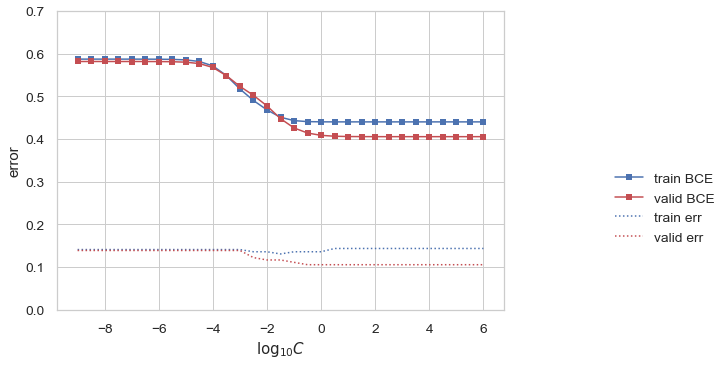

In [29]:
# We will fit a separate logistic regression for each C value in the C_grid
# And store that classifier's performance metrics (lower is better)
# So we can compare and select the best C in the future steps.

model_F3_list = list()

# Allocate lists for storing BCE metrics
tr_bce_list = list()
va_bce_list = list()
te_bce_list = list()

# Allocate lists for storing ERROR RATE metrics
tr_err_list = list()
va_err_list = list()
te_err_list = list()

# Remember, we justified BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.

# Loop over C values, fit models, record metrics
for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize a LogisticRegression classifier with desired C value
    # Part b: train the model with the 2-feature dataset
    lr_F3 = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=C) # TODO fixme
    lr_F3.fit(x_tr_M3[:], y_tr_M[:]) # TODO fixme
    
    model_F3_list.append(lr_F3)
    
    yproba1_tr_M = lr_F3.predict_proba(x_tr_M3)[:,1] # The probability of predicting class 1 on the training set
    yproba1_va_N = lr_F3.predict_proba(x_va_N3)[:,1] # The probability of predicting class 1 on the validation set
    
    # Compute error rate aka zero-one loss
    my_tr_err = sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)
    my_va_err = sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)
    tr_err_list.append(my_tr_err)
    va_err_list.append(my_va_err)
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my_tr_bce = calc_mean_binary_cross_entropy_from_probas(y_tr_M, yproba1_tr_M) # TODO fixme
    my_va_bce = calc_mean_binary_cross_entropy_from_probas(y_va_N, yproba1_va_N) # TODO fixme
    # Save bce for future selection on Models.
    tr_bce_list.append(my_tr_bce) 
    va_bce_list.append(my_va_bce) 


plt.plot(np.log10(C_grid), tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), va_bce_list, 'rs-', label='valid BCE')

plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 0.7]);

**TODO**:
* Select the best C and retrieve the best model. You should name the model as "**best_lrF3**".

In [30]:
# Find the best C with the smallest cross entropy loss on the validation set
index = va_bce_list.index(min(va_bce_list))
best_C__lrF3 = C_grid[index] # TODO fixme
print("Best C value for F3 model:")
print(best_C__lrF3)

best_lrF3 = model_F3_list[index] # TODO fixme

print("Best model has coefficient values:")
print(best_lrF3.coef_)

Best C value for F3 model:
1000000.0
Best model has coefficient values:
[[0.26004524 0.52017581 0.78979623]]


**TODO**:
* Return the posibility of predicting true on training, validation and test set.

In [31]:
# TODO: Return the posibility of predicting true on training, validation and test set.
# Hint: follow what's done in the last code block of Step 1C.

prng = np.random.RandomState(101)
bestlrF3_yproba1_tr_M = best_lrF3.predict_proba(x_tr_M3)[:,1]
bestlrF3_yproba1_va_N = best_lrF3.predict_proba(x_va_N3)[:,1]
bestlrF3_yproba1_te_N = best_lrF3.predict_proba(x_te_N3)[:,1]

## Implementation Step 1E : Comparing Models using ROC Analysis
**TODO**:
Follow the instruction to produce the figure for your report

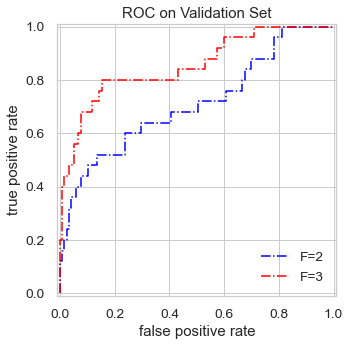

In [32]:
# Follow the instruction of HW2 and produce Figure 1 for your report:
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

# TODO Use provided data and predictions on the Validation set
# Produce the ROC Curve utilizing `sklearn.metrics.roc_curve' within plt defined above.
# To start, read the official Document and examples of 'sklearn.metrics.roc_curve'. 

fpr_2, tpr_2, thresholds_2 = sklearn.metrics.roc_curve(y_va_N, bestlrF2_yproba1_va_N)
fpr_3, tpr_3, thresholds_3 = sklearn.metrics.roc_curve(y_va_N, bestlrF3_yproba1_va_N)

# Read HW2 instructions carefully for plot style (line type, line color, etc.)

plt.title("ROC on Validation Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.plot(fpr_2, tpr_2, color = 'blue', linestyle = '-.', label='F=2')
plt.plot(fpr_3, tpr_3, color = 'red', linestyle = '-.', label='F=3')
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);
plt.legend(loc='lower right');

### Figure 1 for the report: Comparing models using ROC analysis
**TODO**:
Show the figure above in your report

#### Short Answer 1b in Report

*See instructions in the Piazza post for HW2*

## Implementation Step 1F & 1G: Selecting a decision threshold


**TODO**: Follow the instructions below to produce Figure 2

Each column should correspond to one of the following models:

* F=3 Logistic Regression (from 1D above), using threshold 0.5
* F=3 Logistic Regression (from 1D above), using threshold from **1F** (See **Figure2 Column2** for implementation instruction)
* F=3 Logistic Regression (from 1D above), using threshold from **1G** (See **Figure2 Column3** for implementation instruction)

Each row should report some performance of the model on the **test** set:
* Title: **Threshold** **(with 3 digits after decimal)** + which case (i.e **default**, **PPV >= 0.98** or **TPR>=0.98**)
* Top Row: **Confusion Matrix** on the test set. **(with Integers)**
* Bottom Row: **TPR** and **PPV** metrics on the test set. **(with 3 digits after decimal)**

We've offered an example output on each column of Figure 2, but feel free to print out all the value needed and organize them with any software (Jupyter Notebook, Excel, Latex, etc). Then, 
**combine all columns into one figure and include it in your PDF report.**

An example of Figure2 looks like
**"figure2_sample.png"** in the same folder as your starter code.
![image.png](figure2_sample.png)

### Figure2 Column1: Use F=3 LR model, Use default 0.5 threshold
#### TODO:
* Produce the confusion matrix
* Return TPR and PPV on the test set

In [33]:
best_thr_default = 0.5
conf_matrix = calc_confusion_matrix_for_probas_and_threshold(y_te_N, bestlrF3_yproba1_te_N, best_thr_default)
print(conf_matrix)
yhat_N = [1 if proba > best_thr_default else 0 for proba in bestlrF3_yproba1_te_N]
tpr = calc_TPR(y_te_N, yhat_N)
ppv = calc_PPV(y_te_N, yhat_N)

print(f"Figure2 column 1: chosen thr = {best_thr_default :.4f}, tpr = {tpr :.4f}, ppv = {ppv :.4f},")

Predicted    0   1
True              
0          152   3
1           15  10
Figure2 column 1: chosen thr = 0.5000, tpr = 0.4000, ppv = 0.7692,


### Step 1F : Use F=3 LR model, Pick threshold to maximize TPR s.t. PPV >= 0.98

**TODO**: Finish the code block to get the best threshold.

In [34]:
# Get the performance metrics across many thresholds
thresh_grid, va_perf_grid = threshold_selection.compute_perf_metrics_across_thresholds(
    y_va_N, bestlrF3_yproba1_va_N)



In [35]:
# Find threshold that makes TPR as large as possible, while satisfying PPV >= 0.98
# TODO Find the the largest TPR while PPV >= 0.98
tpr1 = 0
ppv1 = 0.0
best_thr_tpr = 0.0

for index in range(len(va_perf_grid['ppv'])):
        if(va_perf_grid['ppv'][index] >= 0.98 and va_perf_grid['tpr'][index] > tpr1):
                tpr1 = va_perf_grid['tpr'][index]
                ppv1 = va_perf_grid['ppv'][index]
                best_thr_tpr = thresh_grid[index]

      

print(f"Figure2 column 2: chosen thr = {best_thr_tpr :.4f}, tpr = {tpr1 :.4f}, ppv = {ppv1 :.4f},")

Figure2 column 2: chosen thr = 0.6311, tpr = 0.2000, ppv = 1.0000,


**TODO**: Using the chosen **best_thr** above
* Produce the confusion matrix
* Return TPR and PPV on the test set

In [36]:
print(calc_confusion_matrix_for_probas_and_threshold(y_te_N, bestlrF3_yproba1_te_N, best_thr_tpr))

Predicted    0  1
True             
0          155  0
1           20  5


### Step 1G: Use F=3 LR model, Pick threshold to maximize PPV s.t. TPR >= 0.98

#### TODO: 
Using a similar logistic from **Step 1F** above
* Choose threshold that makes PPV as large as possible, while satisfying TPR >= 0.98
* Produce the confusion matrix using the chosen threshold
* Return TPR and PPV on the test set using the chosen threshold

In [37]:
# TODO Find the largest PPV while TPR >= 0.98
best_thr_ppv = 0.5 # TODO fixme
tpr2 = 0.0 # TODO fixme
ppv2 = 0.0 # TODO fixme

for index in range(len(va_perf_grid['ppv'])):
        if(va_perf_grid['tpr'][index] >= 0.98 and va_perf_grid['ppv'][index] > ppv2):
                tpr2 = va_perf_grid['tpr'][index]
                ppv2 = va_perf_grid['ppv'][index]
                best_thr_ppv = thresh_grid[index]
      

print("Figure2 column 3: chosen thr = %.4f, tpr = %.4f, ppv = %.4f" % (best_thr_ppv, tpr2, ppv2))
print(calc_confusion_matrix_for_probas_and_threshold(y_te_N, bestlrF3_yproba1_te_N, best_thr_ppv))

Figure2 column 3: chosen thr = 0.0296, tpr = 1.0000, ppv = 0.1852
Predicted   0   1
True             
0          57  98
1           0  25


Once you finish all three parts of figure 2, plase **combine all 3 column** into **one figure** and include it in your PDF report. 

Remember to **add titles** (Threshold + which case) to each column.

#### Short Answer 1c and 1d in Report

*See instructions in the piazza post for HW2*